In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
from math import log, sqrt, exp
from scipy.stats import norm
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [28]:
def get_risk_free_rate_yfinance(dates, ticker="^FVX"):
    start_date = pd.to_datetime(dates.min()).strftime('%Y-%m-%d')
    end_date = pd.to_datetime(dates.max()).strftime('%Y-%m-%d')
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"No data retrieved for ticker {ticker} in the date range.")
    
    data.index = pd.to_datetime(data.index)
    data = data.reindex(pd.date_range(start_date, end_date)).ffill().bfill()
    return data.reset_index()

In [ ]:
df = pd.read_csv("aapl_2016_2020.csv")
data = df.loc[:,[' [QUOTE_DATE]',' [UNDERLYING_LAST]',' [EXPIRE_DATE]',' [DTE]',' [C_LAST]',' [C_BID]', ' [C_ASK]',
                 ' [STRIKE]',' [P_BID]',' [P_ASK]',' [P_LAST]', ' [STRIKE_DISTANCE]', ' [C_IV]', ' [P_IV]']]

data = data.rename(columns={' [QUOTE_DATE]': 'quote_date',' [UNDERLYING_LAST]': 'underlying_last',' [EXPIRE_DATE]': 'expire_date',
    ' [DTE]': 'time_to_expiry_days', ' [C_LAST]': 'call_last',' [C_BID]': 'call_bid',' [C_ASK]': 'call_ask',' [STRIKE]': 'strike',
    ' [P_BID]': 'put_bid', ' [P_ASK]': 'put_ask', ' [P_LAST]': 'put_last',' [STRIKE_DISTANCE]': 'strike_distance',' [C_IV]': 'call_iv',
    ' [P_IV]':"put_iv"
})

/var/folders/pk/90dn4p5556l45snxl195_hlm0000gn/T/ipykernel_34836/1993713807.py:1: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("aapl_2016_2020.csv")


In [30]:
data_prices = data[["quote_date","underlying_last"]].groupby("quote_date").last()
data_prices.sort_values(inplace=True, by="underlying_last")
data_prices.reset_index(inplace=True)
data_prices['quote_date'] = pd.to_datetime(data_prices["quote_date"],errors='coerce')
data_prices['log_return'] = np.log(data_prices['underlying_last']/ data_prices['underlying_last'].shift(1))
data_prices.fillna(0,inplace=True)
data_prices["rolling_vol"] = data_prices['log_return'].rolling(252).std()
data_prices['annualized_vol'] = data_prices['rolling_vol'] * np.sqrt(252)

# 1. Estimate Volatility using price changes and changing to annualized

In [ ]:
data["quote_date"] = pd.to_datetime(data["quote_date"])
data["underlying_last"] = pd.to_numeric(data["underlying_last"], errors='coerce')
data["time_to_expiry_days"] = pd.to_numeric(data["time_to_expiry_days"], errors='coerce')
data["strike"] = pd.to_numeric(data["strike"], errors='coerce')
data["strike_distance"] = pd.to_numeric(data["strike_distance"], errors='coerce')
data["call_last"] = pd.to_numeric(data["call_last"], errors='coerce')
data["call_bid"] = pd.to_numeric(data["call_bid"], errors='coerce')
data["call_ask"] = pd.to_numeric(data["call_ask"], errors='coerce')
data["put_bid"] = pd.to_numeric(data["put_bid"], errors='coerce')
data["put_ask"] = pd.to_numeric(data["put_ask"], errors='coerce')
data["put_last"] = pd.to_numeric(data["put_last"], errors='coerce')
data["call_iv"] = pd.to_numeric(data["call_iv"], errors='coerce')
data["put_iv"] = pd.to_numeric(data["put_iv"], errors='coerce')
data["expire_date"] = pd.to_datetime(data["expire_date"], errors='coerce')
df_1 = data.copy()
unique_dates = data.drop_duplicates(subset=['quote_date'])
data_rf = get_risk_free_rate_yfinance(unique_dates['quote_date'])
data_rf = data_rf.loc[:,["index","Close"]]
data_rf.columns = ["index","Close"]
data['quote_date'] = pd.to_datetime(data['quote_date'])
data_rf['index'] = pd.to_datetime(data_rf['index'])
data = pd.merge(data, data_rf, left_on='quote_date', right_on='index', how='left')
data = data.loc[:,["quote_date","underlying_last","time_to_expiry_days","strike","strike_distance",	"Close","expire_date","call_last","call_bid",
                   "call_ask","put_bid","put_ask","put_last","call_iv","put_iv"]]
data.rename(columns={"Close":"risk_free_rate"},inplace=True)
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,quote_date,underlying_last,time_to_expiry_days,strike,strike_distance,risk_free_rate,expire_date,call_last,call_bid,call_ask,put_bid,put_ask,put_last,call_iv,put_iv
0,2019-01-02,157.92,2.0,100.0,57.9,2.503,2019-01-04,57.20,57.70,58.10,0.00,0.02,0.01,3.25314,1.62555
1,2019-01-02,157.92,2.0,130.0,27.9,2.503,2019-01-04,27.23,27.25,29.60,0.00,0.01,0.01,1.54085,0.73427
2,2019-01-02,157.92,2.0,136.0,21.9,2.503,2019-01-04,21.80,21.25,23.35,0.00,0.02,0.02,1.17751,0.61760
3,2019-01-02,157.92,2.0,141.0,16.9,2.503,2019-01-04,17.80,16.25,18.46,0.02,0.05,0.03,0.96019,0.54751
4,2019-01-02,157.92,2.0,142.0,15.9,2.503,2019-01-04,15.05,15.71,17.50,0.03,0.05,0.04,1.00784,0.52870


In [ ]:
df_1 = pd.merge(data, data_prices[['quote_date', 'annualized_vol']],
                on='quote_date', how='left')
df_1.dropna(inplace=True)
df_1.reset_index(drop=True,inplace=True)

def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0:
        if option_type == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    else:
        return K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

df_1['T'] = df_1['time_to_expiry_days'] / 365.0
tqdm.pandas()  

df_1['call_bs_price'] = df_1.progress_apply(
    lambda row: black_scholes_price(
        S=row['underlying_last'],
        K=row['strike'],
        T=row['T'],
        r=row['risk_free_rate'],
        sigma=row['annualized_vol'],
        option_type='call'
    ),
    axis=1
)

df_1['put_bs_price'] = df_1.progress_apply(
    lambda row: black_scholes_price(
        S=row['underlying_last'],
        K=row['strike'],
        T=row['T'],
        r=row['risk_free_rate'],
        sigma=row['annualized_vol'],
        option_type='put'
    ),
    axis=1
)

100%|██████████| 731411/731411 [01:13<00:00, 9917.67it/s] 


48.98356085821487
20.46655665648912


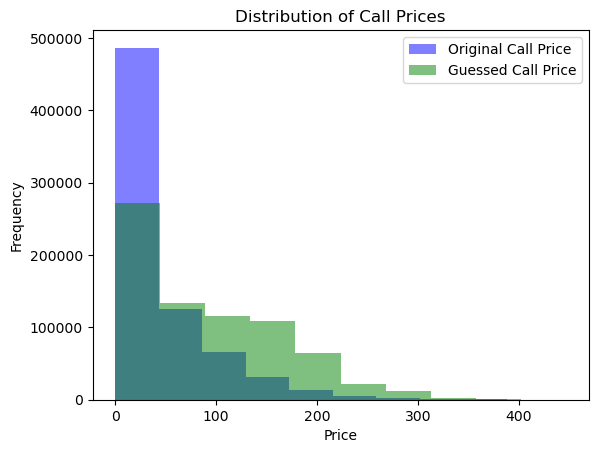

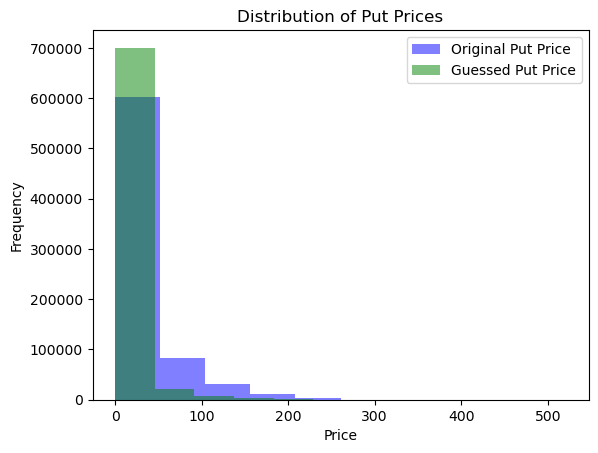

In [ ]:
df_1["original_call_price"] = (df_1["call_bid"] + df_1["call_ask"]) / 2
df_1["original_put_price"]  = (df_1["put_bid"]  + df_1["put_ask"])  / 2
df_1["call_diff"] = np.abs(df_1["call_bs_price"] - df_1["original_call_price"])
df_1["put_diff"]  = np.abs(df_1["put_bs_price"]  - df_1["original_put_price"])
print(df_1["call_diff"].mean())
print(df_1["put_diff"].mean())

# Plot distributions of call prices
plt.hist(df_1["original_call_price"], alpha=0.5, label='Original Call Price', color='blue')
plt.hist(df_1["call_bs_price"], alpha=0.5, label='Guessed Call Price', color='green')
plt.title("Distribution of Call Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()
# Plot distributions of put prices
plt.hist(df_1["original_put_price"], alpha=0.5, label='Original Put Price', color='blue')
plt.hist(df_1["put_bs_price"], alpha=0.5, label='Guessed Put Price', color='green')
plt.title("Distribution of Put Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 2. Use MCS instead of BS

In [35]:
df_2 = pd.merge(data, data_prices[['quote_date', 'annualized_vol']],
                on='quote_date', how='left')
df_2.dropna(inplace=True)
df_2.reset_index(drop=True,inplace=True)
df_2

,quote_date,underlying_last,time_to_expiry_days,strike,strike_distance,risk_free_rate,expire_date,call_last,call_bid,call_ask,put_bid,put_ask,put_last,call_iv,put_iv,annualized_vol
0,2019-01-02,157.92,2.00,100.0,57.9,2.503,2019-01-04,57.20,57.70,58.10,0.00,0.02,0.01,3.25314,1.62555,0.028776
1,2019-01-02,157.92,2.00,130.0,27.9,2.503,2019-01-04,27.23,27.25,29.60,0.00,0.01,0.01,1.54085,0.73427,0.028776
2,2019-01-02,157.92,2.00,136.0,21.9,2.503,2019-01-04,21.80,21.25,23.35,0.00,0.02,0.02,1.17751,0.61760,0.028776
3,2019-01-02,157.92,2.00,141.0,16.9,2.503,2019-01-04,17.80,16.25,18.46,0.02,0.05,0.03,0.96019,0.54751,0.028776
4,2019-01-02,157.92,2.00,142.0,15.9,2.503,2019-01-04,15.05,15.71,17.50,0.03,0.05,0.04,1.00784,0.52870,0.028776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731406,2017-03-31,143.67,658.04,185.0,41.3,1.929,2019-01-18,5.40,4.70,5.26,44.95,46.81,0.00,0.22435,0.17738,0.028411
731407,2017-03-31,143.67,658.04,190.0,46.3,1.929,2019-01-18,4.23,3.89,4.34,48.44,51.10,0.00,0.22095,0.16132,0.028411
731408,2017-03-31,143.67,658.04,195.0,51.3,1.929,2019-01-18,3.48,3.30,3.80,52.60,55.44,54.02,0.22197,0.14528,0.028411
731409,2017-03-31,143.67,658.04,200.0,56.3,1.929,2019-01-18,2.90,2.75,3.10,57.00,60.10,58.72,0.21900,0.12459,0.028411


In [36]:
tqdm.pandas()

def calculate_option_prices(row, num_simulations=10000, risk_free_rate=0.05):
    S = row['underlying_last']  
    K = row['strike']          
    T = row['time_to_expiry_days'] / 365 
    sigma = row['annualized_vol']
    risk_free_rate=row['risk_free_rate']

    # Simulate paths
    Z = np.random.normal(0, 1, num_simulations)
    ST = S * np.exp((risk_free_rate - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Option payoff
    call_payoffs = np.maximum(ST - K, 0)
    put_payoffs = np.maximum(K - ST, 0)

    # Discounted payoffs
    call_price = np.exp(-risk_free_rate * T) * np.mean(call_payoffs)
    put_price = np.exp(-risk_free_rate * T) * np.mean(put_payoffs)

    return pd.Series({'mcs_call_price': call_price, 'mcs_put_price': put_price})

def monte_carlo_simulation(data, num_simulations=10000, risk_free_rate=0.05):

    results = data.progress_apply(
        lambda row: calculate_option_prices(row, num_simulations, risk_free_rate), axis=1
    )
    
    data[['mcs_call_price', 'mcs_put_price']] = results
    return data

df_2 = monte_carlo_simulation(df_2)

100%|██████████| 731411/731411 [05:41<00:00, 2143.35it/s]


48.983702803075964
20.466560486436602


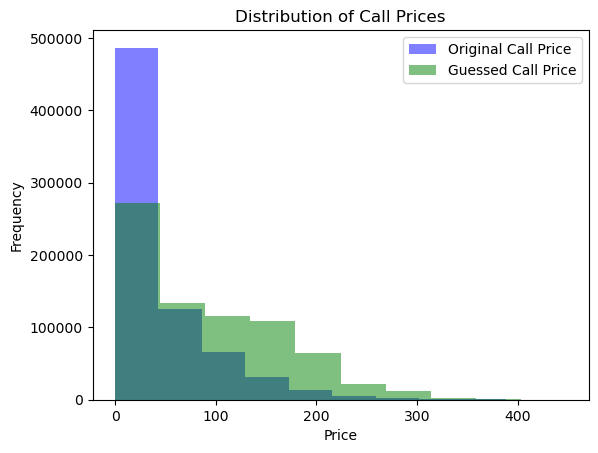

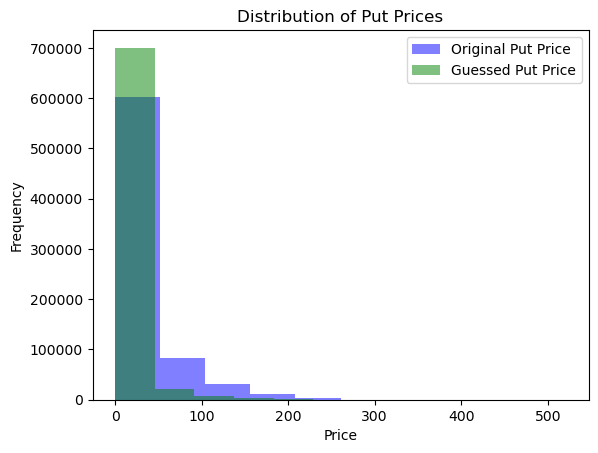

In [37]:
df_2["original_call_price"] = (df_2["call_bid"] + df_2["call_ask"]) / 2
df_2["original_put_price"]  = (df_2["put_bid"]  + df_2["put_ask"])  / 2
df_2["call_diff"] = np.abs(df_2["mcs_call_price"] - df_2["original_call_price"])
df_2["put_diff"]  = np.abs(df_2["mcs_put_price"]  - df_2["original_put_price"])
print(df_2["call_diff"].mean())
print(df_2["put_diff"].mean())

# Plot distributions of call prices
plt.hist(df_2["original_call_price"], alpha=0.5, label='Original Call Price', color='blue')
plt.hist(df_2["mcs_call_price"], alpha=0.5, label='Guessed Call Price', color='green')
plt.title("Distribution of Call Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()
# Plot distributions of put prices
plt.hist(df_2["original_put_price"], alpha=0.5, label='Original Put Price', color='blue')
plt.hist(df_2["mcs_put_price"], alpha=0.5, label='Guessed Put Price', color='green')
plt.title("Distribution of Put Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# 3.Using ML For Volatility and MCS for pricing

In [38]:
df_3 = pd.merge(data, data_prices[['quote_date', 'annualized_vol']],
                on='quote_date', how='left')
df_3.dropna(inplace=True)
df_3.reset_index(drop=True,inplace=True)
df_3.head()

,quote_date,underlying_last,time_to_expiry_days,strike,strike_distance,risk_free_rate,expire_date,call_last,call_bid,call_ask,put_bid,put_ask,put_last,call_iv,put_iv,annualized_vol
0,2019-01-02,157.92,2.0,100.0,57.9,2.503,2019-01-04,57.20,57.70,58.10,0.00,0.02,0.01,3.25314,1.62555,0.028776
1,2019-01-02,157.92,2.0,130.0,27.9,2.503,2019-01-04,27.23,27.25,29.60,0.00,0.01,0.01,1.54085,0.73427,0.028776
2,2019-01-02,157.92,2.0,136.0,21.9,2.503,2019-01-04,21.80,21.25,23.35,0.00,0.02,0.02,1.17751,0.61760,0.028776
3,2019-01-02,157.92,2.0,141.0,16.9,2.503,2019-01-04,17.80,16.25,18.46,0.02,0.05,0.03,0.96019,0.54751,0.028776
4,2019-01-02,157.92,2.0,142.0,15.9,2.503,2019-01-04,15.05,15.71,17.50,0.03,0.05,0.04,1.00784,0.52870,0.028776


In [39]:
df_3['moneyness'] = df_3['underlying_last'] / df_3['strike']
df_3.columns

Index(['quote_date', 'underlying_last', 'time_to_expiry_days', 'strike',
       'strike_distance', 'risk_free_rate', 'expire_date', 'call_last',
       'call_bid', 'call_ask', 'put_bid', 'put_ask', 'put_last', 'call_iv',
       'put_iv', 'annualized_vol', 'moneyness'],
      dtype='object')

In [45]:
# Correlations
df_3[['underlying_last', 'strike', 'strike_distance', 'risk_free_rate', 'annualized_vol', 'moneyness']].corr()


,underlying_last,strike,strike_distance,risk_free_rate,annualized_vol,moneyness
underlying_last,1.000000,0.662935,0.420480,-0.446975,0.763446,-0.002616
strike,0.662935,1.000000,0.130265,-0.280257,0.495947,-0.275309
strike_distance,0.420480,0.130265,1.000000,-0.199343,0.351122,0.254257
risk_free_rate,-0.446975,-0.280257,-0.199343,1.000000,-0.540077,0.026350
annualized_vol,0.763446,0.495947,0.351122,-0.540077,1.000000,-0.010354
moneyness,-0.002616,-0.275309,0.254257,0.026350,-0.010354,1.000000


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
# Prepare the data
print("Preparing data...")
features = ['underlying_last', 'time_to_expiry_days', 'strike',
            'strike_distance', 'risk_free_rate', 'annualized_vol','moneyness']
target_call = 'call_iv'
target_put = 'put_iv'
df_3.sort_values(by='quote_date',inplace=True)
df_3.reset_index(inplace=True,drop=True)
X = df_3[features]
y_call = df_3[target_call]
y_put = df_3[target_put]
print(f"Data preparation completed")


start_time = time.time()
print("Splitting data into training and testing sets...")
X_train_call, X_test_call, y_train_call, y_test_call = train_test_split(X, y_call, test_size=0.2, random_state=42)
X_train_put, X_test_put, y_train_put, y_test_put = train_test_split(X, y_put, test_size=0.2, random_state=42)
print(f"Data splitting completed in {time.time() - start_time:.2f} seconds.")

# Train Random Forest Regressor for call_iv
start_time = time.time()
print("Training Random Forest Regressor for call_iv...")
rf_call = RandomForestRegressor(random_state=42)
rf_call.fit(X_train_call, y_train_call)
print(f"Training completed in {time.time() - start_time:.2f} seconds.")

# Train Random Forest Regressor for put_iv
start_time = time.time()
print("Training Random Forest Regressor for put_iv...")
rf_put = RandomForestRegressor(random_state=42)
rf_put.fit(X_train_put, y_train_put)
print(f"Training completed in {time.time() - start_time:.2f} seconds.")

# Evaluate the models
start_time = time.time()
print("Evaluating models...")
y_pred_call = rf_call.predict(X_test_call)
y_pred_put = rf_put.predict(X_test_put)
print("Call IV Model Performance:")
print("MSE:", mean_squared_error(y_test_call, y_pred_call))
print("R²:", r2_score(y_test_call, y_pred_call))
print("Put IV Model Performance:")
print("MSE:", mean_squared_error(y_test_put, y_pred_put))
print("R²:", r2_score(y_test_put, y_pred_put))
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")

Preparing data...
Data preparation completed
Splitting data into training and testing sets...
Data splitting completed in 0.09 seconds.
Training Random Forest Regressor for call_iv...
Training completed in 466.52 seconds.
Training Random Forest Regressor for put_iv...
Training completed in 454.29 seconds.
Evaluating models...
Call IV Model Performance:
MSE: 0.0650696497040782
R²: 0.9108992679406246
Put IV Model Performance:
MSE: 0.006584571572586396
R²: 0.973840603324601
Evaluation completed in 41.33 seconds.


In [47]:
importances = rf_call.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

importances = rf_put.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

               Feature  Importance
6            moneyness    0.444808
1  time_to_expiry_days    0.403732
4       risk_free_rate    0.048526
5       annualized_vol    0.032613
0      underlying_last    0.026935
3      strike_distance    0.025269
2               strike    0.018116
               Feature  Importance
6            moneyness    0.490570
1  time_to_expiry_days    0.362811
3      strike_distance    0.061825
4       risk_free_rate    0.040562
0      underlying_last    0.017792
5       annualized_vol    0.016066
2               strike    0.010374


In [48]:
start_time = time.time()
print("Predicting for new data...")
df_3['predicted_call_iv'] = rf_call.predict(X)
df_3['predicted_put_iv'] = rf_put.predict(X)
print(f"Prediction completed in {time.time() - start_time:.2f} seconds.")

Predicting for new data...
Prediction completed in 65.53 seconds.


In [50]:
def calculate_option_prices(row, num_simulations=10000, risk_free_rate=0.05):
    S = row['underlying_last']  # Current stock price
    K = row['strike']           # Strike price
    T = row['time_to_expiry_days'] / 365  # Time to expiry in years
    sigma = row['annualized_vol']
    risk_free_rate=row['risk_free_rate']

    # Simulate paths
    Z = np.random.normal(0, 1, num_simulations)
    ST = S * np.exp((risk_free_rate - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Option payoff
    call_payoffs = np.maximum(ST - K, 0)
    put_payoffs = np.maximum(K - ST, 0)

    # Discounted payoffs
    call_price = np.exp(-risk_free_rate * T) * np.mean(call_payoffs)
    put_price = np.exp(-risk_free_rate * T) * np.mean(put_payoffs)

    return pd.Series({'mcs_call_price': call_price, 'mcs_put_price': put_price})

def monte_carlo_simulation(data, num_simulations=10000, risk_free_rate=0.05):
    # Apply the calculation row-wise with progress bar
    results = data.progress_apply(
        lambda row: calculate_option_prices(row, num_simulations, risk_free_rate), axis=1
    )
    
    # Add results back to the original DataFrame
    data[['mcs_call_price', 'mcs_put_price']] = results
    return data

def calculate_option_prices(row, num_simulations=10000, risk_free_rate=0.05):
    S = row['underlying_last']  # Current stock price
    K = row['strike']           # Strike price
    T = row['time_to_expiry_days'] / 365  # Time to expiry in years
    risk_free_rate = row['risk_free_rate']
    # Simulate paths
    Z = np.random.normal(0, 1, num_simulations)
    sigma = row['predicted_call_iv']
    ST = S * np.exp((risk_free_rate - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    call_payoffs = np.maximum(ST - K, 0)
    call_price = np.exp(-risk_free_rate * T) * np.mean(call_payoffs)
    sigma = row['predicted_put_iv']
    ST = S * np.exp((risk_free_rate - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    put_payoffs = np.maximum(K - ST, 0)
    put_price = np.exp(-risk_free_rate * T) * np.mean(put_payoffs)
    return pd.Series({'mcs_call_price': call_price, 'mcs_put_price': put_price})
def monte_carlo_simulation(data, num_simulations=10000, risk_free_rate=0.05):
    # Apply the calculation row-wise with progress bar
    results = data.progress_apply(
        lambda row: calculate_option_prices(row, num_simulations, risk_free_rate), axis=1
    )
    
    data[['mcs_call_price', 'mcs_put_price']] = results
    return data


df_3 = monte_carlo_simulation(df_3)

100%|██████████| 731411/731411 [06:56<00:00, 1756.78it/s]


50.13305048196053
19.137027998943438


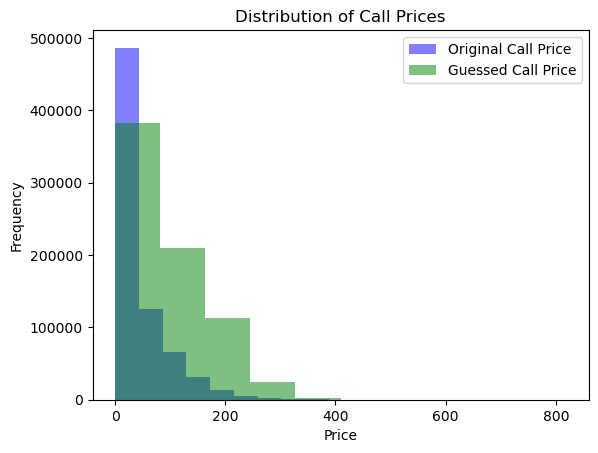

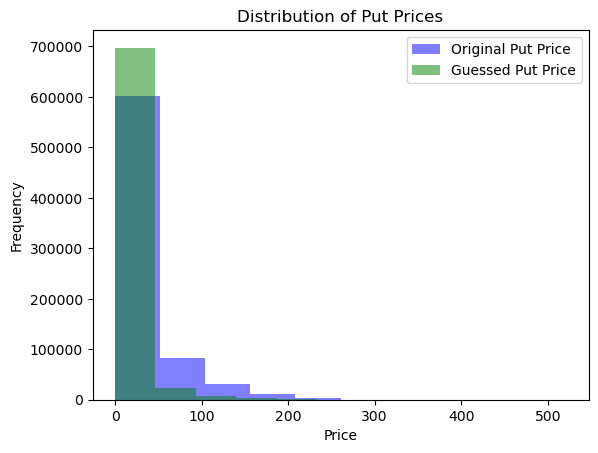

In [51]:
df_3["original_call_price"] = (df_3["call_bid"] + df_3["call_ask"]) / 2
df_3["original_put_price"]  = (df_3["put_bid"]  + df_3["put_ask"])  / 2
df_3["call_diff"] = np.abs(df_3["mcs_call_price"] - df_3["original_call_price"])
df_3["put_diff"]  = np.abs(df_3["mcs_put_price"]  - df_3["original_put_price"])
print(df_3["call_diff"].mean())
print(df_3["put_diff"].mean())

# Plot distributions of call prices
plt.hist(df_3["original_call_price"], alpha=0.5, label='Original Call Price', color='blue')
plt.hist(df_3["mcs_call_price"], alpha=0.5, label='Guessed Call Price', color='green')
plt.title("Distribution of Call Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist(df_3["original_put_price"], alpha=0.5, label='Original Put Price', color='blue')
plt.hist(df_3["mcs_put_price"], alpha=0.5, label='Guessed Put Price', color='green')
plt.title("Distribution of Put Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Using ML for Pricing

In [52]:
df_4 = pd.merge(data, data_prices[['quote_date', 'annualized_vol']],
                on='quote_date', how='left')
df_4.dropna(inplace=True)
df_4.reset_index(drop=True,inplace=True)
df_4["original_call_price"] = (df_4["call_bid"] + df_4["call_ask"]) / 2
df_4["original_put_price"]  = (df_4["put_bid"]  + df_4["put_ask"])  / 2
df_4.head()
df_4['moneyness'] = df_4['underlying_last'] / df_4['strike']
df_4.head()

,quote_date,underlying_last,time_to_expiry_days,strike,strike_distance,risk_free_rate,expire_date,call_last,call_bid,call_ask,put_bid,put_ask,put_last,call_iv,put_iv,annualized_vol,original_call_price,original_put_price,moneyness
0,2019-01-02,157.92,2.0,100.0,57.9,2.503,2019-01-04,57.20,57.70,58.10,0.00,0.02,0.01,3.25314,1.62555,0.028776,57.900,0.010,1.579200
1,2019-01-02,157.92,2.0,130.0,27.9,2.503,2019-01-04,27.23,27.25,29.60,0.00,0.01,0.01,1.54085,0.73427,0.028776,28.425,0.005,1.214769
2,2019-01-02,157.92,2.0,136.0,21.9,2.503,2019-01-04,21.80,21.25,23.35,0.00,0.02,0.02,1.17751,0.61760,0.028776,22.300,0.010,1.161176
3,2019-01-02,157.92,2.0,141.0,16.9,2.503,2019-01-04,17.80,16.25,18.46,0.02,0.05,0.03,0.96019,0.54751,0.028776,17.355,0.035,1.120000
4,2019-01-02,157.92,2.0,142.0,15.9,2.503,2019-01-04,15.05,15.71,17.50,0.03,0.05,0.04,1.00784,0.52870,0.028776,16.605,0.040,1.112113


In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
# Prepare the data
print("Preparing data...")
features = ['underlying_last', 'time_to_expiry_days', 'strike',
            'strike_distance', 'risk_free_rate', 'annualized_vol','moneyness']
target_call = 'original_call_price'
target_put = 'original_put_price'
df_4.sort_values(by='quote_date',inplace=True)
df_4.reset_index(inplace=True,drop=True)
X = df_4[features]
y_call = df_4[target_call]
y_put = df_4[target_put]
print(f"Data preparation completed")


start_time = time.time()
print("Splitting data into training and testing sets...")
X_train_call, X_test_call, y_train_call, y_test_call = train_test_split(X, y_call, test_size=0.2, random_state=42)
X_train_put, X_test_put, y_train_put, y_test_put = train_test_split(X, y_put, test_size=0.2, random_state=42)
print(f"Data splitting completed in {time.time() - start_time:.2f} seconds.")

# Train Random Forest Regressor for call_iv
start_time = time.time()
print("Training Random Forest Regressor for call_iv...")
rf_call = RandomForestRegressor(random_state=42)
rf_call.fit(X_train_call, y_train_call)
print(f"Training completed in {time.time() - start_time:.2f} seconds.")

# Train Random Forest Regressor for put_iv
start_time = time.time()
print("Training Random Forest Regressor for put_iv...")
rf_put = RandomForestRegressor(random_state=42)
rf_put.fit(X_train_put, y_train_put)
print(f"Training completed in {time.time() - start_time:.2f} seconds.")

# Evaluate the models
start_time = time.time()
print("Evaluating models...")
y_pred_call = rf_call.predict(X_test_call)
y_pred_put = rf_put.predict(X_test_put)
print("Call IV Model Performance:")
print("MSE:", mean_squared_error(y_test_call, y_pred_call))
print("R²:", r2_score(y_test_call, y_pred_call))
print("Put IV Model Performance:")
print("MSE:", mean_squared_error(y_test_put, y_pred_put))
print("R²:", r2_score(y_test_put, y_pred_put))
print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")

importances = rf_call.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

importances = rf_put.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

Preparing data...
Data preparation completed
Splitting data into training and testing sets...
Data splitting completed in 0.11 seconds.
Training Random Forest Regressor for call_iv...
Training completed in 415.80 seconds.
Training Random Forest Regressor for put_iv...
Training completed in 444.66 seconds.
Evaluating models...
Call IV Model Performance:
MSE: 0.28078813857013457
R²: 0.9998983058138464
Put IV Model Performance:
MSE: 0.29343681161279855
R²: 0.9998263678400853
Evaluation completed in 48.03 seconds.
               Feature  Importance
6            moneyness    0.660432
3      strike_distance    0.321804
1  time_to_expiry_days    0.010331
0      underlying_last    0.003481
5       annualized_vol    0.002793
4       risk_free_rate    0.001018
2               strike    0.000142
               Feature  Importance
6            moneyness    0.705322
3      strike_distance    0.264065
1  time_to_expiry_days    0.015782
2               strike    0.010855
4       risk_free_rate    0.0

Predicting new columns using trained models...
0.14688060632120667
0.135898194380451


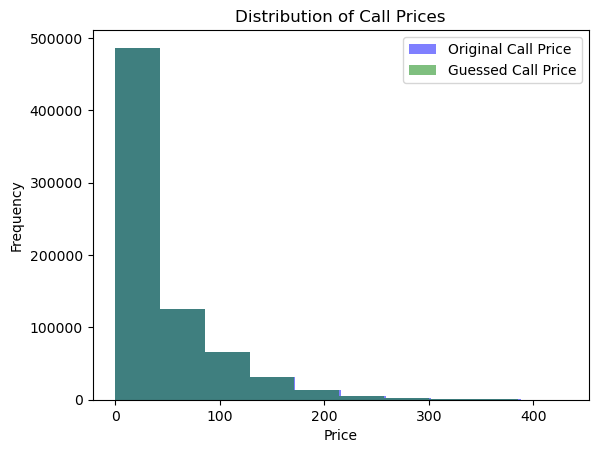

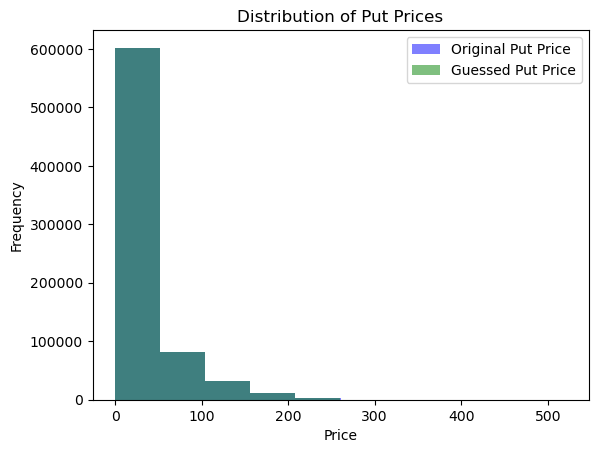

In [55]:
required_features = ['underlying_last', 'time_to_expiry_days', 'strike', 
                     'strike_distance', 'risk_free_rate', 'annualized_vol','moneyness']

print("Predicting new columns using trained models...")
df_4['predicted_call_price'] = rf_call.predict(df_4[required_features])
df_4['predicted_put_price'] = rf_put.predict(df_4[required_features])

df_4["call_diff"] = np.abs(df_4["predicted_call_price"] - df_4["original_call_price"])
df_4["put_diff"]  = np.abs(df_4["predicted_put_price"]  - df_4["original_put_price"])
print(df_4["call_diff"].mean())
print(df_4["put_diff"].mean())

# Plot distributions of call prices
plt.hist(df_4["original_call_price"], alpha=0.5, label='Original Call Price', color='blue')
plt.hist(df_4["predicted_call_price"], alpha=0.5, label='Guessed Call Price', color='green')
plt.title("Distribution of Call Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist(df_4["original_put_price"], alpha=0.5, label='Original Put Price', color='blue')
plt.hist(df_4["predicted_put_price"], alpha=0.5, label='Guessed Put Price', color='green')
plt.title("Distribution of Put Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()